# event boxplot
This notebook is dedicated to extracting counts values for specific alternative splicing events or gene expression differences.
For example:
```
fromGTF.SE.txt:10149	"ENSG00000229807.11"	"XIST"	chrX	-	73831065	73831274	73829067	73829231	73833237	73833374
```
Here 10149 is a valid key for all  rmats_final.se* files

In [64]:
from collections import defaultdict
import os
import gzip
import requests
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
base_dir = '../data'

In [44]:
def get_srr_pdata_map():
    fname = os.path.join(base_dir, 'srr_pdata.csv')
    if not os.path.exists(fname):
        raise Error("srr_pdata.csv cannot be found")
    srr_dict = defaultdict(int)
    with open(fname) as f:
        reader = csv.DictReader(f, delimiter=",")
        for row in reader: 
            srr = row['SRR']
            sex = int(row['SEX'])
            srr_dict[srr] = sex
    return srr_dict

In [45]:
## This is probably not needed! Can be deleted

def download_subject_phenotypes_if_needed():
    fname = os.path.join(base_dir, 'GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt')
    if os.path.exists(fname):
        print("GTEx phenotype file alreaday downloaded")
    pheno_url = 'https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt'
    r = requests.get(pheno_url)
    if r is None:
        raise Exception("Could not download pheno URL")
    fname = os.path.join(base_dir, 'GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt')
    fh = open(fname, 'wt')
    fh.write(r.text)

# download_subject_phenotypes_if_needed()  

In [37]:
## This is probably not needed! Can be deleted
def get_subject_phenotypes():
    fname = os.path.join(base_dir, 'GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt')
    if not os.path.exists(fname):
        raise Error("GTEx phenotype file must be downloaded first")
    subjectdict = defaultdict(int)
    with open(fname) as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            subjectdict[row['SUBJID']] = int(row['SEX'])
        
        
# get_subject_phenotypes()

In [79]:
def get_rmats_files(category, typ):
    """
    category is a string such as SE or A3SS
    """
    lccat = category.lower()
    valid_cats = {'se', 'mxe', 'ri', 'a3ss', 'a5ss'}
    files = []
    if not lccat in valid_cats:
        raise ValueError("Invalid category passed: \"%s\"" % category)
    search_string = 'rmats_final.%s' % lccat
    for file in os.listdir(base_dir):
        if search_string in file and typ in file:
            #print(os.path.join(base_dir, file))
            files.append(os.path.join(base_dir, file))
    return files
    

In [67]:
def get_inc_dot_txt_values(path, rmats_id, srr_dict):
    """
    path: path to a rmats_final.*.jc.inc.txt.gz file, where * is one of 'se', 'mxe', 'ri', 'a3ss', 'a5ss'
    rmats_id: id of the splicing event, e.g., fromGTF.SE.txt:10149 is event 10149 in the "se" file.
    """
    searchstring = "%s," % rmats_id
    values_m = []
    values_f = []
    with gzip.open(fname,'rt') as f:
        header = next(f)
        header_fields = header.rstrip().split(",")[1:]
        not_found = 0
        for line in f:
            if line.startswith(searchstring):
                fields = line.rstrip().split(",")
                for i in range(1, len(header_fields)):
                    val = float(fields[i])
                    srr = header_fields[i]
                    if srr in srr_dict:
                        if srr_dict[srr] == 1:
                            values_m.append(val)
                        elif srr_dict[srr] == 2:
                            values_f.append(val)
                        else:
                            raise ValueError("Unknown gender code: ", srr_dict[srr])
                    else:
                        #print("[WARN] could not find %s in srr_dict." % srr)
                        not_found += 1
    print("Not found samples, ", not_found)
    return values_m, values_f
            

In [81]:
def get_jc_txt_values(path, rmats_id, srr_dict):
    """
    path: path to a rmats_final.*.jc.inc.txt.gz file, where * is one of 'se', 'mxe', 'ri', 'a3ss', 'a5ss'
    rmats_id: id of the splicing event, e.g., fromGTF.SE.txt:10149 is event 10149 in the "se" file.
    """
    searchstring = "%s," % rmats_id
    m_dict = defaultdict(float)
    f_dict = defaultdict(float)
    with gzip.open(fname,'rt') as f:
        header = next(f)
        header_fields = header.rstrip().split(",")[1:]
        not_found = 0
        for line in f:
            if line.startswith(searchstring):
                fields = line.rstrip().split(",")
                for i in range(1, len(header_fields)):
                    val = float(fields[i])
                    srr = header_fields[i]
                    if srr in srr_dict:
                        if srr_dict[srr] == 1:
                            m_dict[srr] = val
                        elif srr_dict[srr] == 2:
                            f_dict[srr] = val
                        else:
                            raise ValueError("Unknown gender code: ", srr_dict[srr])
                    else:
                        #print("[WARN] could not find %s in srr_dict." % srr)
                        not_found += 1
    print("Not found samples, ", not_found)
    return m_dict, f_dict

def get_psi(sjc_path, ijc_path, rmats_id, srr_dict):
    m_ijc_dict, f_ijc_dict = get_jc_txt_values(ijc_path, rmats_id, srr_dict)
    m_sjc_dict, f_sjc_dict = get_jc_txt_values(sjc_path, rmats_id, srr_dict)
    m_values = []
    f_values = []
    for k, ijc in m_ijc_dict.items():
        if k in m_sjc_dict:
            sjc = m_sjc_dict.get(k)
            denom = ijc+sjc
            if denom == 0:
                continue
            psi = ijc/denom
            m_values.append(psi)
    for k, ijc in f_ijc_dict.items():
        if k in f_sjc_dict:
            sjc = f_sjc_dict.get(k)
            denom = ijc+sjc
            if denom == 0:
                continue
            psi = ijc/denom
            f_values.append(psi)
    return m_values, f_values
            

In [68]:
files = get_rmats_files("SE")
for f in files:
    print(f)

../data/rmats_final.se.jc.inc.txt.gz


In [75]:
fname = files[0]
srr_dict = get_srr_pdata_map()
#values_m, values_f = get_inc_dot_txt_values(files[0], "10151", srr_dict)



Not found samples,  801


In [80]:
ijc_file = get_rmats_files('SE', 'ijc.txt')
sjc_file = get_rmats_files('SE', 'sjc.txt')
print("ijc: %s; sjc: %s" % (ijc_file, sjc_file))
m_values, f_values = get_psi(sjc_file, ijc_file, rmats_id=)

ijc: ['../data/rmats_final.se.jc.ijc.txt.gz']; sjc: ['../data/rmats_final.se.jc.sjc.txt.gz']


In [76]:
len(srr_dict)

7872

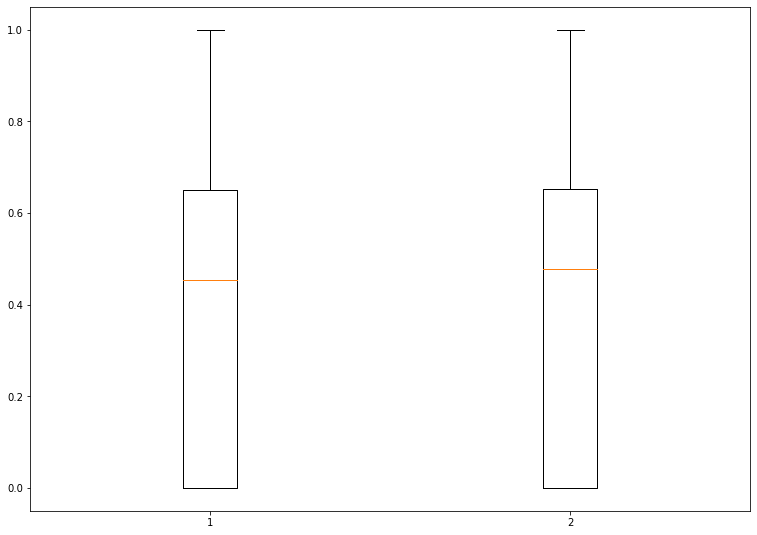

In [77]:
data = [np.array(values_m), np.array(values_f)] 
  
fig = plt.figure(figsize =(10, 7)) 
  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
  
# Creating plot 
bp = ax.boxplot(data) 
  
# show plot 
plt.show() 